<a href="https://colab.research.google.com/github/pdh21/OCF_PVmapper/blob/main/DeepNet_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://avatars.githubusercontent.com/u/48357542?s=200&v=4)

## PV mapping Example:
[Peter Hurley](http://pdh21.github.io/) 

In this notebook, we will give a simple example of training a deep net to detect solar panels from remote sensing data. 

As with most neural net projects, we need to:
1. Define training data: input tensors and target tensors. (see this [notebook](https://github.com/pdh21/OCF_PVmapper/blob/main/Example_DeepNet.ipynb) to follow converting cutouts to Tensorflow record format)
2. Define a network of layers (or model ) that maps inputs to targets.
3. Configure the learning process by choosing a loss function, an optimizer
some metrics to monitor.
4. Iterate on training data by calling the fit() method of your model.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
cd gdrive/MyDrive/PVmapping/

cutouts/  cutouts_tfrecords/  OCF_PVmapping_doc.gdoc


In [6]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

FILE_PATTERN='./*aerial*.tif'
OUTPUT = './cutouts_tfrecords/'  # prefix for output file names
TARGET_SIZE = [75,75]

SHARDS = 16


Tensorflow version 2.4.1


## Read  from TFRecord Dataset

In [7]:
def read_tfrecord(example):
    features = {
        "image_aerial": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "image_binary": tf.io.FixedLenFeature([], tf.string),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers

    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image_aerial = tf.image.decode_jpeg(example['image_aerial'], channels=3)
    image_aerial = tf.reshape(image_aerial, [*TARGET_SIZE, 3])

    image_binary = tf.image.decode_jpeg(example['image_binary'], channels=1)
    image_binary = tf.reshape(image_binary, [*TARGET_SIZE, 1])
    
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    return image_aerial,image_binary, label, height, width
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

In [12]:
display_dataset = dataset4.map(lambda image_aerial,image_binary,label, height, width: (image_aerial,image_binary,label))

In [19]:
def display_9_images_from_dataset(dataset):
  fig,axes=plt.subplots(9,2,figsize=(5,20))
  for i, (image_aerial,image_binary,label) in enumerate(dataset):
    axes[i,0].imshow(image_aerial.numpy().astype(np.uint8))
    axes[i,1].imshow(image_binary.numpy().astype(np.uint8)[:,:,0])
    axes[i,0].set_title(label.numpy().decode("utf-8"), fontsize=16)
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.show()

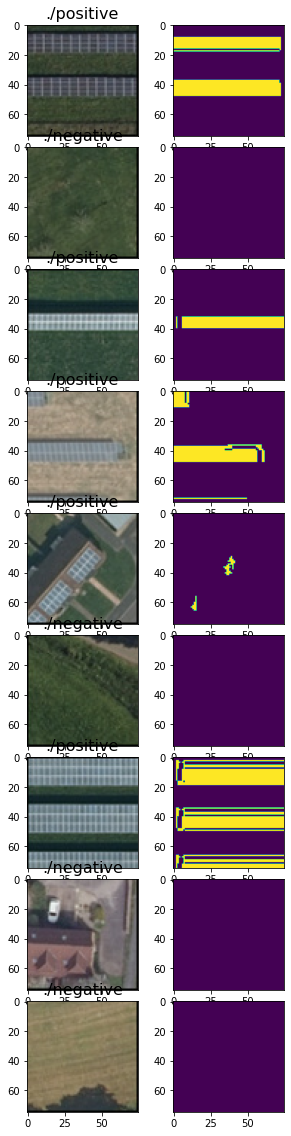

In [18]:
display_9_images_from_dataset(display_dataset)